In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [522]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import starry
from scipy.optimize import minimize

starry.config.quiet = True

In [494]:
ydeg = 20
map = starry.Map(ydeg, lazy=False)

In [566]:
def y(l, sigma):
    return (1 + sigma) ** (-l ** 2)

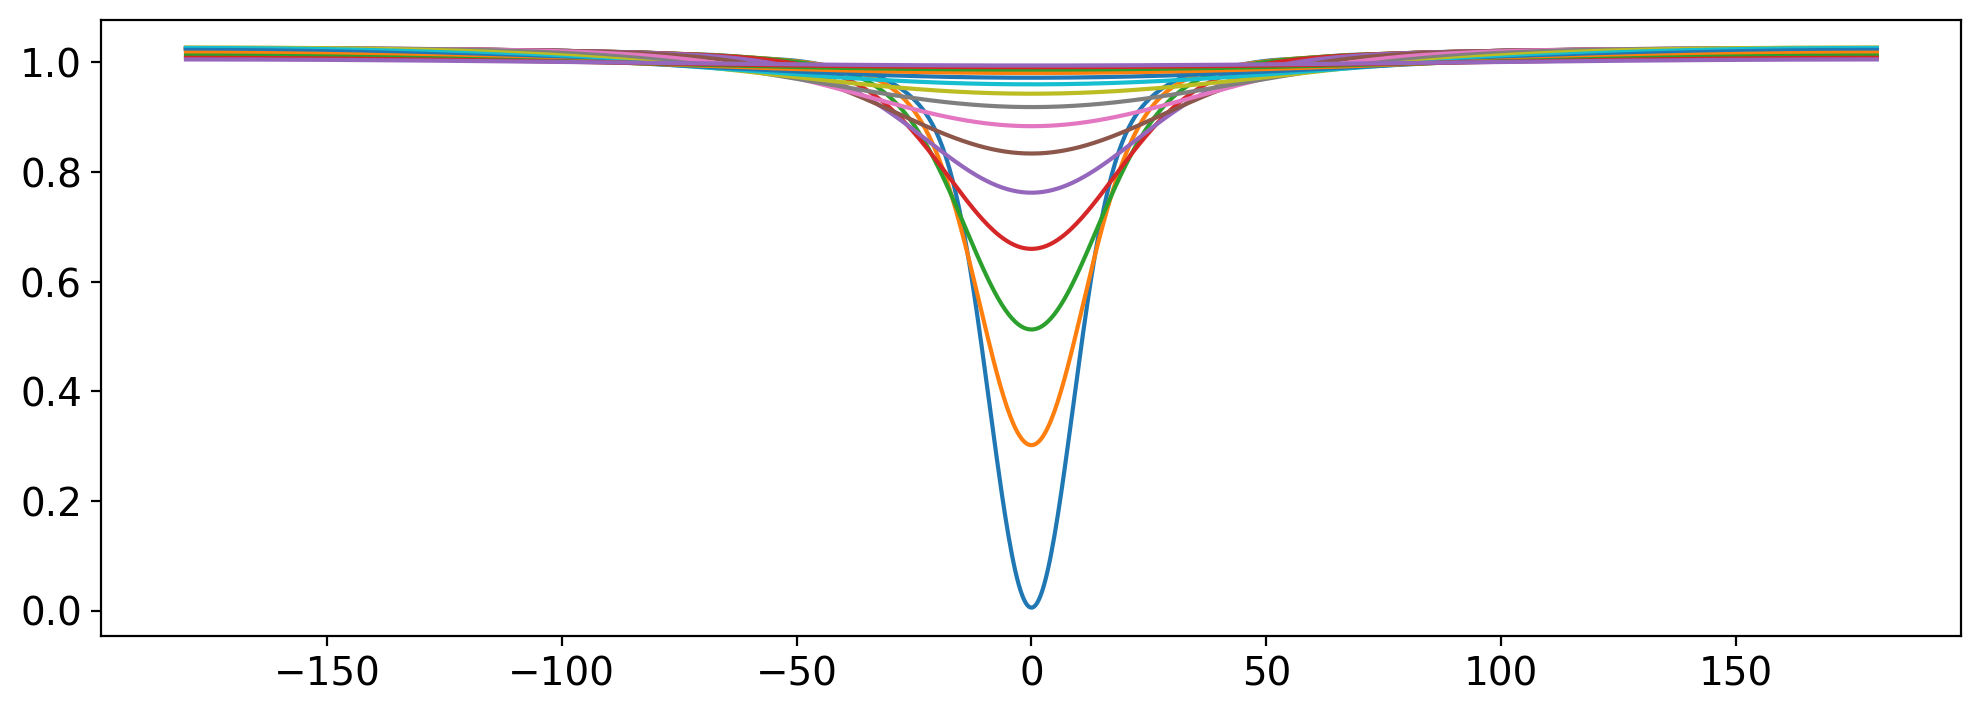

In [653]:
sigma = np.logspace(-2, 0, 15)
amp = 0.035
lon = np.linspace(-180, 180, 1000)

fig, ax = plt.subplots(1, figsize=(12, 4))
for k in range(len(sigma)):
    map[1:, 0] = -amp * np.array([y(l, sigma[k]) for l in range(1, map.ydeg + 1)])
    ax.plot(lon, np.pi * map.intensity(lon=lon));

In [ ]:
sigma = np.logspace(-5, 0, 15)
amp = 0.035
fig, ax = plt.subplots(3, 5)
ax = ax.flatten()
cnorm = colors.Normalize(vmin=0, vmax=1)
for k in range(len(sigma)):
    map[1:, 0] = -amp * np.array([y(l, sigma[k]) for l in range(1, map.ydeg + 1)])
    map.show(ax=ax[k], projection="ortho")

Normalization tests

In [547]:
def Imax(sigma, ydeg):
    l = np.arange(1, ydeg + 1).reshape(1, -1)
    return (1 + np.sum(np.sqrt(2 * l + 1) * (1 + sigma.reshape(-1, 1)) ** (-l ** 2), axis=1)) / np.pi

def norm(x, sigma):
    a, b, c = x
    return a * (1 + sigma) ** b * sigma ** c

def diff(x, sigma, ydeg):
    return np.sum((Imax(sigma, ydeg) * norm(x, sigma) - 1) ** 2)

sigma = np.logspace(-2, 0, 50)
res = minimize(diff, [3, -0.5, 0.5], args=(sigma, ydeg))
print(res.x)

[ 2.58043674 -0.74467569  0.68812647]


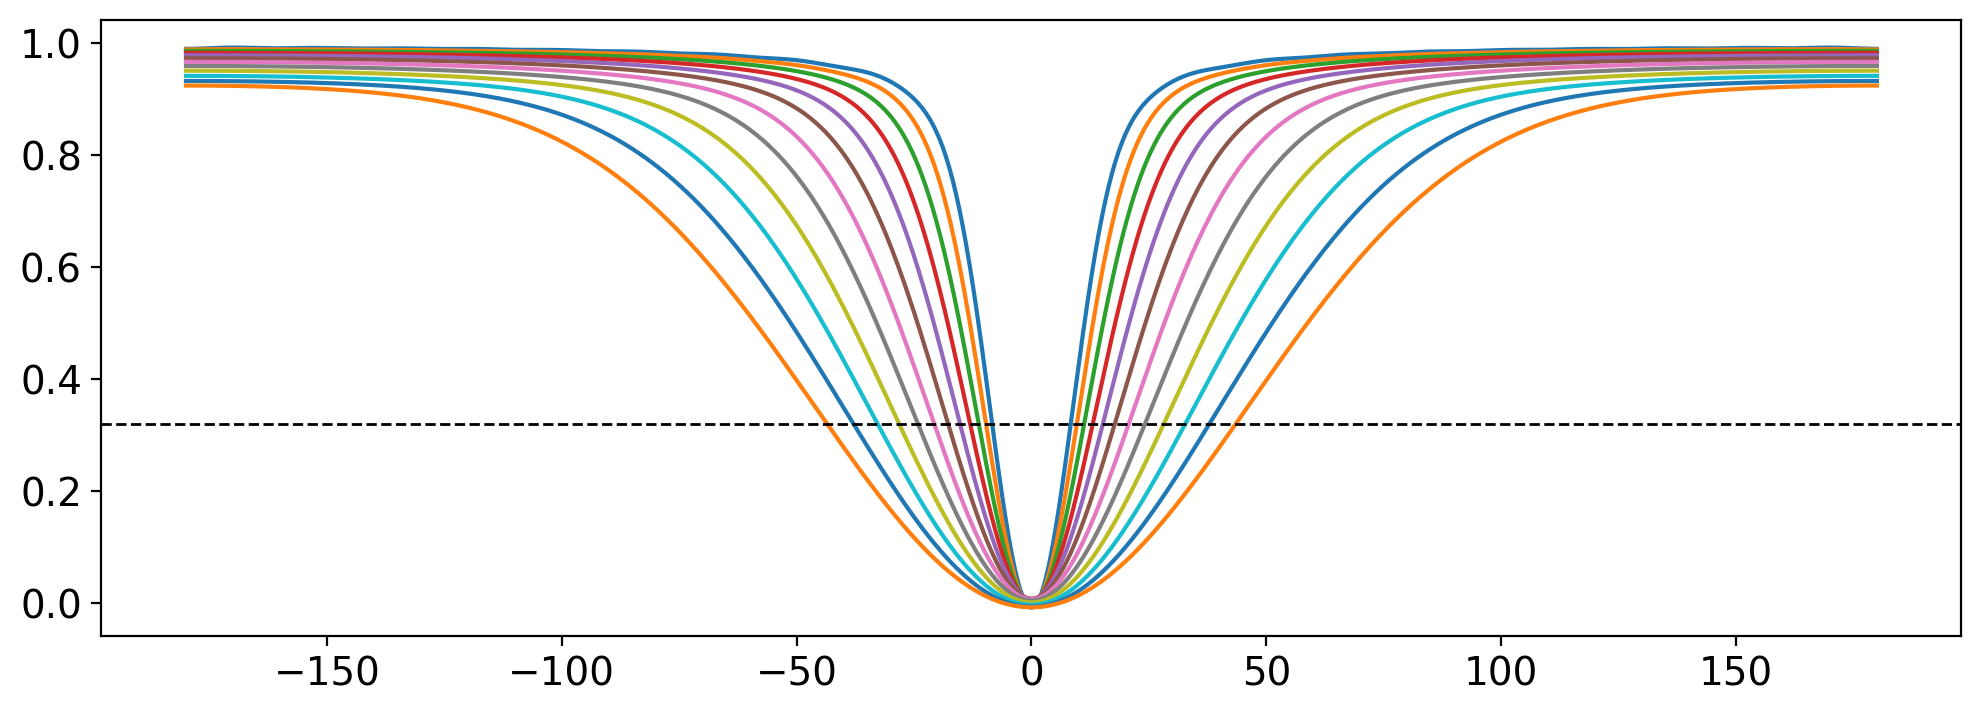

In [628]:
sigma = np.logspace(-2, 0, 15)[:-3]
lon = np.linspace(-180, 180, 1000)

fig, ax = plt.subplots(1, figsize=(12, 4))
for k in range(len(sigma)):
    
    N = norm(res.x, sigma[k])
    y1 = np.array([y(l, sigma[k]) for l in range(1, map.ydeg + 1)])
    y_ = -N * y1 / (np.pi - N)
    amp = (np.pi - N)
    map[1:, 0] = y_
    map.amp = amp
    ax.plot(lon, map.intensity(lon=lon))
    
ax.axhline(1 / np.pi, color="k", ls="--", lw=1);